# FBXO11
[Intellectual developmental disorder with dysmorphic facies and behavioral abnormalities (IDDFBA)](https://omim.org/entry/618089) is caused by heterozygous mutation in the [FBXO11 gene](https://omim.org/entry/607871). Almost all  affected individuals presented with mild to severe intellectual disability and global developmental delay. F-box proteins, such as FBXO11, contain an approximately 40-amino acid motif, the F box, that binds SKP1. Reported pathogenic variants include pathogenic variants include likely gene-disrupting (LGD) variants, missense variants, deletion of partial exons, and CNVs. Published literature has not reported a genotype-phenotype correlation to date. The following articles were consulted:


- [Gregor A, et al. (2018) De Novo Variants in the F-Box Protein FBXO11 in 20 Individuals with a Variable Neurodevelopmental Disorder. Am J Hum Genet](https://pubmed.ncbi.nlm.nih.gov/30057029/)
- [Jansen S, et al. (2019) De novo variants in FBXO11 cause a syndromic form of intellectual disability with behavioral problems and dysmorphisms. Eur J Hum Genet. 2019](https://pubmed.ncbi.nlm.nih.gov/30679813/)
- [Pan X, et al (2024) FBXO11 variants are associated with intellectual disability and variable clinical manifestation in Chinese affected individuals. J Hum Genet.](https://pubmed.ncbi.nlm.nih.gov/38740982/)

Our analysis of 56 individuals failed to show a significant genotype phenotype correlation, in accordance with current literature.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


### FBXO11
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FBXO11.

In [2]:
gene_symbol = "FBXO11"
mane_tx_id = 'NM_001190274.2'
mane_protein_id = 'NP_001177203.1' # F-box only protein 11 isoform 4

In [3]:
from ppktstore.registry import configure_phenopacket_registry
registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(release="0.1.23") as ps:
  phenopackets = list(ps.iter_cohort_phenopackets("FBXO11"))
print(f"Found cohort with {len(phenopackets)} phenopackets for FBXO11")
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
   phenopackets=phenopackets,
   cohort_creator=cohort_creator,
)
validation.summarize()

Found cohort with 56 phenopackets for FBXO11
Individuals Processed: 100%|██████████| 56/56 [01:39<00:00,  1.78s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
54,Global developmental delay
32,Intellectual disability
25,Delayed speech and language development
22,Hypotonia
18,Delayed ability to walk
16,Thin upper lip vermilion
14,Autistic behavior
13,Overweight
13,Strabismus
12,Seizure


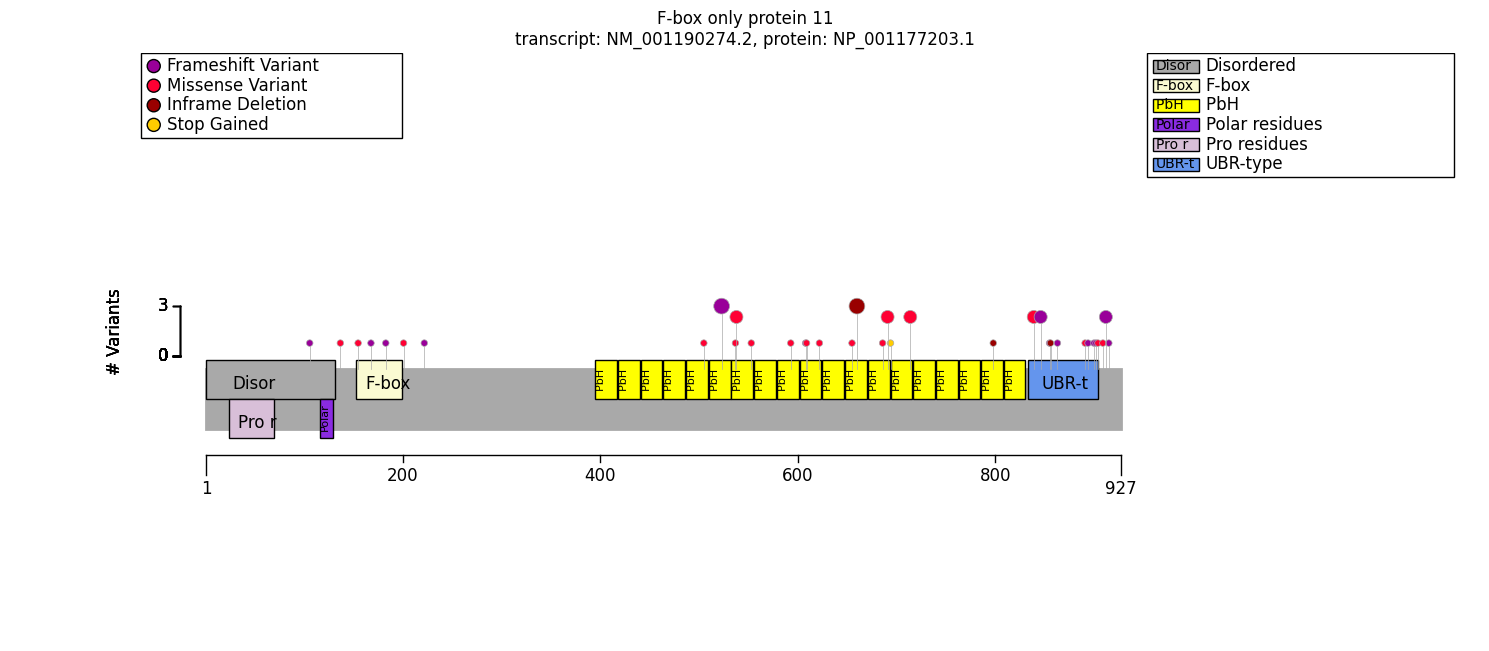

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fbxo11_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fbxo11_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
1,Disordered,Region,2 - 132,p.Leu107AlafsTer45
0,Pro residues,Compositional bias,25 - 70,
0,Polar residues,Compositional bias,117 - 130,
3,F-box,Domain,154 - 199,p.Ser169LeufsTer9; p.Gln156Arg; p.Lys184AsnfsTer27
0,PbH1 1,Repeat,396 - 417,
0,PbH1 2,Repeat,419 - 440,
0,PbH1 3,Repeat,442 - 463,
0,PbH1 4,Repeat,465 - 486,
1,PbH1 5,Repeat,488 - 509,p.Tyr506Cys
3,PbH1 6,Repeat,511 - 532,p.Asn524ThrfsTer15


# Genotype Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label='Missense',
    b_label='Other'
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,113
HMF03,Skipping term because of a child term with the same individual counts,7
HMF08,Skipping general term,71
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,186


In [10]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense          Other  \
                                                      Count Percent  Count   
Overweight [HP:0025502]                                1/12      8%  12/22   
Seizure [HP:0001250]                                   8/19     42%   4/33   
Hypotonia [HP:0001252]                                13/17     76%   9/23   
Strabismus [HP:0000486]                                8/14     57%   7/17   
Delayed ability to walk [HP:0031936]                    5/9     56%  13/20   
Global developmental delay [HP:0001263]               20/20    100%  34/34   
Neurodevelopmental delay [HP:0012758]                 20/20    100%  34/34   
Neurodevelopmental abnormality [HP:0012759]           21/21    100%  35/35   
Abnormal oral cavity morphology [HP:0000163]            8/8    100%  18/18   
Abnormality of the mouth [HP:0000153]                   8/8    100%  18/18   
Abnormal eyelid morphology [HP:0000492]                 9/9    100%  18/18   
Abnormal ocular adnexa morphology [HP:0030669]          9/9    100%  18/18   
Abnormal lip morphology [HP:0000159]                    8/8    100%  17/17   
Delayed speech and language development [HP:000...      8/8    100%  17/17   
Abnormal communication [HP:0034434]                     8/8    100%  17/17   
Intellectual disability [HP:0001249]                  10/10    100%  22/22   

Allele group                                                                   \
                                                   Percent Corrected p values   
Overweight [HP:0025502]                                55%           0.142267   
Seizure [HP:0001250]                                   12%           0.142267   
Hypotonia [HP:0001252]                                 39%           0.142267   
Strabismus [HP:0000486]                                41%           1.000000   
Delayed ability to walk [HP:0031936]                   65%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Abnormality of the mouth [HP:0000153]                 100%           1.000000   
Abnormal eyelid morphology [HP:0000492]               100%           1.000000   
Abnormal ocular adnexa morphology [HP:0030669]        100%           1.000000   
Abnormal lip morphology [HP:0000159]                  100%           1.000000   
Delayed speech and language development [HP:000...    100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   

Allele group                                                  
                                                    p values  
Overweight [HP:0025502]                             0.010745  
Seizure [HP:0001250]                                0.019396  
Hypotonia [HP:0001252]                              0.026675  
Strabismus [HP:0000486]                             0.479488  
Delayed ability to walk [HP:0031936]                0.694153  
Global developmental delay [HP:0001263]             1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Abnormal oral cavity morphology [HP:0000163]        1.000000  
Abnormality of the mouth [HP:0000153]               1.000000  
Abnormal eyelid morphology [HP:0000492]             1.000000  
Abnormal ocular adnexa morphology [HP:0030669]      1.000000  
Abnormal lip morphology [HP:0000159]                1.000000  
Delayed speech and language development [HP:000...  1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Intellectual disability [HP:0001249]                1.000000

In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Overweight [HP:0025502]                              7/13     54%   6/21   
Delayed ability to walk [HP:0031936]                10/13     77%   8/16   
Hypotonia [HP:0001252]                               7/16     44%  15/24   
Strabismus [HP:0000486]                               5/9     56%  10/22   
Global developmental delay [HP:0001263]             20/20    100%  34/34   
Neurodevelopmental delay [HP:0012758]               20/20    100%  34/34   
Neurodevelopmental abnormality [HP:0012759]         21/21    100%  35/35   
Abnormal oral cavity morphology [HP:0000163]          7/7    100%  19/19   
Abnormality of the mouth [HP:0000153]                 7/7    100%  19/19   
Abnormal eyelid morphology [HP:0000492]               6/6    100%  21/21   
Abnormal ocular adnexa morphology [HP:0030669]        6/6    100%  21/21   
Abnormal lip morphology [HP:0000159]                  6/6    100%  19/19   
Delayed speech and language development [HP:000...  11/11    100%  14/14   
Abnormal communication [HP:0034434]                 11/11    100%  14/14   
Intellectual disability [HP:0001249]                15/15    100%  17/17   

Sex                                                                            \
                                                   Percent Corrected p values   
Overweight [HP:0025502]                                29%                1.0   
Delayed ability to walk [HP:0031936]                   50%                1.0   
Hypotonia [HP:0001252]                                 62%                1.0   
Strabismus [HP:0000486]                                45%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Abnormality of the mouth [HP:0000153]                 100%                1.0   
Abnormal eyelid morphology [HP:0000492]               100%                1.0   
Abnormal ocular adnexa morphology [HP:0030669]        100%                1.0   
Abnormal lip morphology [HP:0000159]                  100%                1.0   
Delayed speech and language development [HP:000...    100%                1.0   
Abnormal communication [HP:0034434]                   100%                1.0   
Intellectual disability [HP:0001249]                  100%                1.0   

Sex                                                           
                                                    p values  
Overweight [HP:0025502]                             0.167588  
Delayed ability to walk [HP:0031936]                0.249034  
Hypotonia [HP:0001252]                              0.334521  
Strabismus [HP:0000486]                             0.704251  
Global developmental delay [HP:0001263]             1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Abnormal oral cavity morphology [HP:0000163]        1.000000  
Abnormality of the mouth [HP:0000153]               1.000000  
Abnormal eyelid morphology [HP:0000492]             1.000000  
Abnormal ocular adnexa morphology [HP:0030669]      1.000000  
Abnormal lip morphology [HP:0000159]                1.000000  
Delayed speech and language development [HP:000...  1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Intellectual disability [HP:0001249]                1.000000

# Summary
In the published literature, no genotype-phenotype correlations were established (PMID:34505148). 

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result,
    )
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,16,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,15,0


In [14]:
summarizer.process_latex(report=report, protein_fig=fbxo11_fig)

Figure saved to ../../supplement/img/FBXO11_protein_diagram-draft.pdf
Output to ../../supplement/tex/FBXO11_summary_draft.tex
